In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
data, y = make_classification(
    n_classes=5, n_samples=5000, n_features=15, n_informative=5, n_redundant=2, flip_y=0.05)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])

features = list(data.columns)
train, test, ytrain, ytest = train_test_split(data, y, test_size=0.25)

In [5]:
import lightgbm as lgb
params = {
    'metric': 'multi_logloss',
    'objective': 'multiclass',
    'learning_rate' : 0.05,
    'num_class': len(np.unique(y))
}
cvmodel = lgb.cv(params, 
                 lgb.Dataset(train, ytrain),
                 num_boost_round=10000, 
                 early_stopping_rounds=10,
                 verbose_eval=False)
num_rounds = len(list(cvmodel.items())[0][1])
print('Number of trees:', num_rounds)

gbm = lgb.train(
    params,
    lgb.Dataset(train, ytrain),
    num_boost_round=num_rounds)
print('Model\'s logloss on initial features:', log_loss(ytest, gbm.predict(test)))

Number of trees: 135
Model's logloss on initial features: 0.719172379849


In [6]:
n_runs = 2
f_imp_true = np.zeros(len(features)) # Feature importance for true target.
f_imp_perm = np.zeros(len(features)) # Feature importance for permutated target.

for run in range(n_runs):
    idx = np.arange(len(train))
    np.random.shuffle(idx)
    ytrain_perm = ytrain[idx]
    
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=n_runs+run)
    for train_ind, test_ind in kf.split(train, ytrain):
        
        dtrain = lgb.Dataset(
            train.iloc[train_ind], 
            ytrain[train_ind])
        gbm = lgb.train(params, dtrain, num_boost_round=num_rounds)
        f_imp_true += gbm.feature_importance('gain')
    
        dtrain = lgb.Dataset(
            train.iloc[train_ind],
            ytrain_perm[train_ind])
        gbm = lgb.train(params, dtrain, num_boost_round=num_rounds)
        f_imp_perm += gbm.feature_importance('gain')
        
f_imp_perm /= n_runs
f_imp_true /= n_runs

3.888 f4
3.649 f6
3.26 f11
3.077 f1
3.042 f14
2.812 f5
1.848 f10
0.436 f7
0.406 f3
0.398 f8
0.386 f12
0.374 f15
0.334 f2
0.331 f9
0.324 f13


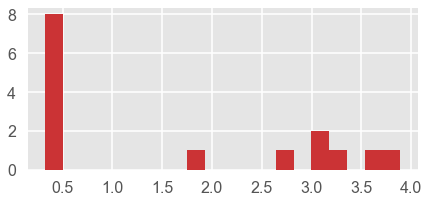

In [10]:
#f_imp = (f_imp_true - f_imp_perm) / (f_imp_true + f_imp_perm + 1)
f_imp = f_imp_true / (f_imp_perm + 1e-3)

for f, imp in (sorted(zip(features, f_imp), key = lambda x: x[1], reverse=True)):
    print (round(imp,3), f)
plt.figure(figsize=(7,3))
plt.hist(f_imp, bins=20);

In [11]:
excluded_features = [features[i] for i in range(len(features)) if f_imp[i]<1]
new_features = list(set(features) - set(excluded_features))

In [48]:
print('Model\'s logloss on initial features:', log_loss(ytest, gbm.predict(test)))

cvmodel = lgb.cv(params, 
                 lgb.Dataset(train[new_features], ytrain),
                 num_boost_round=10000, 
                 early_stopping_rounds=10,
                 verbose_eval=False)
num_rounds = len(list(cvmodel.items())[0][1])
print (num_rounds)

gbm = lgb.train(
    params,
    lgb.Dataset(train[new_features], ytrain),
    num_boost_round=num_rounds)
print('Model\'s logloss on selected features:', log_loss(ytest, gbm.predict(test[new_features])))

191
Model on selected features: 0.74022563621
